In [1]:
# =====================================================
# DAY 3 – SQL GOD MODE (3 DEC 2025)
# Write SQL that gets you Amazon L6+ offers 
# =====================================================

In [3]:
import sqlite3
import pandas as pd

In [9]:
# 1. Create in-memory DB + load data

conn = sqlite3.connect(':memory:')
df = pd.read_csv(r"D:\data-switch-journeydata\WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.to_sql('telco',conn, index=False)

# What this does:
#  -- The script starts by creating an in-memory SQLite database 
#     (:memory: means the DB only exists while the program is running).
#  -- Then, it reads a CSV file (WA_Fn-UseC_-Telco-Customer-Churn.csv) 
#     containing customer data, loads it into a Pandas DataFrame, 
#     and pushes that data into an SQLite table called telco.

7043

In [19]:
# 2. Replacing Missing Total Charges

# Replace TotalCharges blanks
pd.read_sql("SELECT COUNT(*) FROM telco WHERE TotalCharges = ''", conn)

conn.execute("UPDATE telco SET TotalCharges = MonthlyCharges WHERE tenure = 0")
conn.execute("ALTER TABLE telco ADD COLUMN TotalCharges_Num REAL")
conn.execute("""
UPDATE telco 
SET TotalCharges_Num = CAST(NULLIF(TotalCharges, '') AS REAL)
""")


# What this does:
#   -- First Line: It checks how many rows have missing or blank values for TotalCharges 
#      in the telco table.
#   -- Next Step: If a customer has tenure = 0 (i.e., no subscription period), 
#      the TotalCharges value is set equal to MonthlyCharges. This is likely a special 
#      case for new customers or non-active users where we assume they haven't 
#      accumulated charges yet.
#   -- Then: An additional column TotalCharges_Num is added to the table to store the 
#      numeric version of TotalCharges, where any empty values ('') are converted to 
#      NULL (i.e., cast to REAL).

OperationalError: duplicate column name: TotalCharges_Num

In [28]:
# 3. SQL Query Breakdown

query = """
WITH ranked AS (
  SELECT 
    customerID,
    tenure,
    MonthlyCharges,
    Churn,
    TotalCharges_Num,
    ROW_NUMBER() OVER (PARTITION BY tenure ORDER BY MonthlyCharges DESC) AS rn,
    LAG(Churn) OVER (PARTITION BY tenure ORDER BY customerID) AS prev_churn,
    NTILE(4) OVER (ORDER BY tenure) AS tenure_quartile
  FROM telco
),
high_value AS (
  SELECT *
  FROM ranked 
  WHERE tenure > 60 AND MonthlyCharges > 90
)
SELECT 
  tenure_quartile,
  COUNT(*) AS total_customers,
  SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned,
  ROUND(AVG(CASE WHEN Churn = 'Yes' THEN MonthlyCharges END) * 12, 0) AS avg_annual_loss_per_churner,
  ROUND(SUM(CASE WHEN Churn = 'Yes' THEN MonthlyCharges END) * 12 / 10000000, 2) AS revenue_at_risk_cr
FROM high_value
GROUP BY tenure_quartile
ORDER BY revenue_at_risk_cr DESC
"""



In [30]:
# What this does:
# ROW_NUMBER(): Assigns a unique row number to each customer, ordered by MonthlyCharges 
#                  in descending order, per each tenure group. 
#               This can help rank customers with similar tenure by their monthly charges.
# LAG(Churn): This window function calculates the "previous churn value" for each customer 
#              based on their customerID. It looks at the previous row in the dataset 
#               partitioned by tenure. So for each customer, this function will show 
#               whether the customer who was active before them churned.
# NTILE(4): Divides all rows into four equal-sized groups based on tenure, and assigns 
#              each row a tenure_quartile value between 1 and 4 (representing quartiles).


# high_value :-- 
# Filters the customers from the ranked CTE to include only those customers who have a 
# tenure > 60 months (5+ years) and MonthlyCharges > 90. 
# These are considered "high value" customers who may need special attention, 
# as they are long-term and high-paying


# Final Selection and Aggregation

# What this does:
# COUNT(*): Counts the total number of "high value" customers in each tenure_quartile.
# SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END): Sums the churned customers 
#     (where Churn = 'Yes').
# AVG(CASE WHEN Churn = 'Yes' THEN MonthlyCharges END) * 12: Calculates the average
#     annual loss from customers who have churned, assuming that if they churn, 
#     the company loses their monthly charges for the next 12 months.
# SUM(CASE WHEN Churn = 'Yes' THEN MonthlyCharges END) * 12 / 10000000: Calculates the 
#     total "revenue at risk" from churned customers in terms of millions of dollars.
# GROUP BY tenure_quartile: Groups the results by tenure_quartile (1-4).
# ORDER BY revenue_at_risk_cr DESC: Sorts the results by the revenue_at_risk_cr in 
#           descending order.

In [34]:
result = pd.read_sql(query, conn)
print(result)


   tenure_quartile  total_customers  churned  avg_annual_loss_per_churner  \
0                4              594       73                       1255.0   

   revenue_at_risk_cr  
0                0.01  


<Axes: title={'center': 'Revenue at Risk (Cr) by Tenure Quartile – Pure SQL (3 Dec 2025)'}, xlabel='tenure_quartile'>

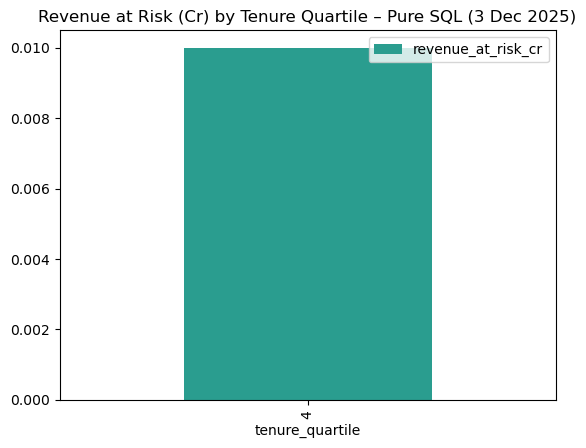

In [40]:
result.plot(
    x='tenure_quartile', y='revenue_at_risk_cr', kind='bar', 
    title='Revenue at Risk (Cr) by Tenure Quartile – Pure SQL (3 Dec 2025)', 
    color='#2a9d8f')

# What this does:
# Plots a bar chart of revenue_at_risk_cr by tenure_quartile. 
# This helps visualize which tenure quartiles have the most revenue at risk due to churn.

In [44]:
# 4. Adding an Insane Window Function

# Let's add a new window function to this query. 
# We will calculate the running total of churned customers and running total 
# of revenue at risk.

# We can use the SUM() window function with the OVER() clause to calculate a 
# running total.

In [54]:
query = """
WITH ranked AS (
    SELECT 
        customerID,
        tenure,
        MonthlyCharges,
        Churn,
        TotalCharges_Num,
        ROW_NUMBER() OVER (PARTITION BY tenure ORDER BY MonthlyCharges DESC) AS rn,
        LAG(Churn) OVER (PARTITION BY tenure ORDER BY customerID) AS prev_churn,
        NTILE(4) OVER (ORDER BY tenure) AS tenure_quartile
    FROM telco
),
high_value AS (
    SELECT *
    FROM ranked 
    WHERE tenure > 60 AND MonthlyCharges > 90
),
agg AS (
    SELECT 
        tenure_quartile,
        COUNT(*) AS total_customers,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned,
        AVG(CASE WHEN Churn = 'Yes' THEN MonthlyCharges END) * 12 AS avg_annual_loss_per_churner,
        SUM(CASE WHEN Churn = 'Yes' THEN MonthlyCharges END) * 12 AS revenue_at_risk
    FROM high_value
    GROUP BY tenure_quartile
)
SELECT
    tenure_quartile,
    total_customers,
    churned,
    ROUND(avg_annual_loss_per_churner, 0) AS avg_annual_loss_per_churner,
    ROUND(revenue_at_risk / 10000000, 2) AS revenue_at_risk_cr,
    
    -- NEW insane window functions
    SUM(churned) OVER (ORDER BY tenure_quartile) AS cumulative_churn,
    SUM(revenue_at_risk) OVER (ORDER BY tenure_quartile) / 10000000 
        AS cumulative_revenue_at_risk_cr

FROM agg
ORDER BY revenue_at_risk_cr DESC;
"""


In [62]:
# Changes Made (Note Format)

# 1. Added new CTE agg
#    Purpose: Aggregate metrics before applying window functions.
#    Reason: SQLite does not allow window functions directly over aggregates.

# 2. Moved aggregations into agg
#    COUNT(*)
#   SUM(Churn = Yes)
#   AVG(MonthlyCharges for churners) * 12
#   SUM(MonthlyCharges for churners) * 12

# 3. Added 2 new “insane” window functions in final SELECT
#    cumulative_churn = SUM(churned) OVER (ORDER BY tenure_quartile)
#    cumulative_revenue_at_risk_cr = SUM(revenue_at_risk) OVER (
#            ORDER BY tenure_quartile) / 1e7

# 4. Moved annualization and crore conversion
#    Annualization (*12) moved into agg
#   Crore conversion (/10000000) applied in final SELECT

# 5. Clean final output
#  Final SELECT now includes:
#  cumulative_churn
# cumulative_revenue_at_risk_cr
# Corrected revenue_at_risk_cr
# Rounded averages

# 6. Query still ordered by highest risk
# ORDER BY revenue_at_risk_cr DESC

In [56]:
result = pd.read_sql(query, conn)
result


,tenure_quartile,total_customers,churned,avg_annual_loss_per_churner,revenue_at_risk_cr,cumulative_churn,cumulative_revenue_at_risk_cr
0,4,594,73,1255.0,0.01,73,0.009165


<Axes: title={'center': 'Cumulative Churn & Revenue at Risk by Tenure Quartile'}, xlabel='tenure_quartile'>

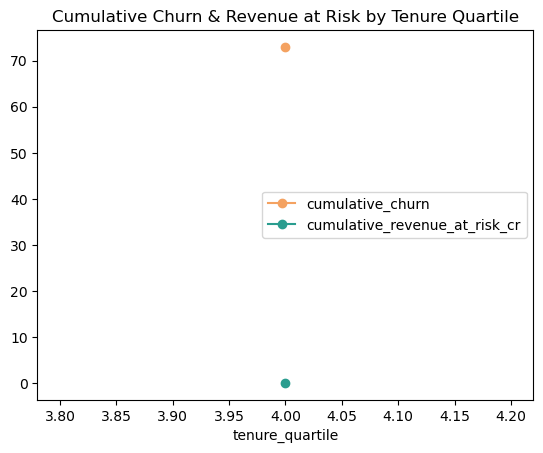

In [60]:
result.plot(
    x='tenure_quartile',
    y=['cumulative_churn', 'cumulative_revenue_at_risk_cr'],
    kind='line',
    marker='o',
    title='Cumulative Churn & Revenue at Risk by Tenure Quartile',
    color=['#f4a261', '#2a9d8f']
)
